This notebook serves as a different take on recreating the research paper titled “Explainable AI for Classification using Probabilistic Logic Inference” by Fan et al. via the study's own sub-algorithms as one cohesive unit. 
The implementation is first preceded by the sklearn Decision Tree module, in an effort to implement any probabilistic framework (Note: DTs rely on probability when utilzing criterion functions such as Entropy or Information Gain).

For an equivalent comparison, entropy criterion was used.

The algorithimic self-implementation for the ID3 Exhaustive Search Decision Tree is based on description and formulas taken from Chapter 8 - Nonmetric Methods, of Duda and Hart's book titled 'Pattern Classification,' Second Edition.

## Initializing:

In [2]:
# Note: Import Required Libraries - you may need to use the command !pip install --user <packagename> if the library is not installed in 
# your Conda Environment.

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import seaborn as sns

### The dataset individually selected for this task can be found at [ Mental Health in Tech Survey](https://www.kaggle.com/osmi/mental-health-in-tech-survey)

This dataset is from a 2014 survey that measures attitudes towards mental health and frequency of mental health disorders in the tech workplace.

<img src="Part 2/images/3.jpg" />

The attribute 'Treatment' will be considered for the binary classification task throughout this notebook. 

However, the beauty of this dataset is that most features can be considered the predictor variable, as long as no. of classes present in the feature does not get exponentially large (such as Age, for example). 

## Reading the Data: 

In [3]:
# Note: Change directory according to where you download and save the data file.

df = pd.read_csv(r"C:\Users\Fizza\Downloads\survey.csv")
df

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,2015-11-30 21:25:06,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN


## Data Pre-processing and Cleaning: 

In [4]:
rowdf = df.shape[0]

# Checking for NA values w.r.t each Attribute in order to be discarded:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

Attributes worth removing:

1) Timestamp - The time of the records are highly unlikely to correlate or affect the consequences of mental health as it contains elements of time the respondent provided his/her data, which is irrelevant.

2) State - Presence of high NA values caused by the fact that it captures info on if the person lives in the US state or not. 
Additionally, mental health consequences can be suffered in any state equally likely to the US, thus incuding this would bring 
about biased and inapt decisions only.

3) Comments - As it was textual in nature, any beneficial value that could be gained from it would be by NLP techniques 
instead. Apart from this, the presence of high NA values indicates that the target audience did not bother populating the 
feature, thus leaving it meaningless for us to exploit.

In [5]:
# Removing NA-heavy and meaningless columns that provide no information for the predicting feature:

df.drop(columns=['Timestamp','state', 'comments'], inplace = True)

# Introducing new feature value replacement for NA values in 'Self Employed' Attribute:

df['self_employed'] = df['self_employed'].replace(np.nan, "Unknown")
df['work_interfere'] = df['work_interfere'].replace(np.nan, "Prefer Not To Say")

df

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,Unknown,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,Unknown,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,Unknown,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,Unknown,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,Unknown,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26,male,United Kingdom,No,No,Yes,Prefer Not To Say,26-100,No,Yes,...,Don't know,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No
1255,32,Male,United States,No,Yes,Yes,Often,26-100,Yes,Yes,...,Yes,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No
1256,34,male,United States,No,Yes,Yes,Sometimes,More than 1000,No,Yes,...,Don't know,Somewhat difficult,Yes,Yes,No,No,No,No,No,No
1257,46,f,United States,No,No,No,Prefer Not To Say,100-500,Yes,Yes,...,Don't know,Don't know,Yes,No,No,No,No,No,No,No


In [6]:
# Check if any NA values remain in dataset:

display(df.isna().sum())

# Check which Attributes will need to be encoded for the classification process:

df.dtypes

Age                          0
Gender                       0
Country                      0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
dtype: int64

Age                           int64
Gender                       object
Country                      object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
dtype: object

In [8]:
# Checking which values in 'Gender' Attribute will need to be encoded due to large quantity and similarity:

df['Gender'].unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [9]:
# Encoding 'Gender' Attribute:

df['Gender'].replace(['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                     'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                      'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make',], 'Male', inplace = True)

df['Gender'].replace(['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                     'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)

df["Gender"].replace(['Female (trans)', 'queer/she/they', 'non-binary',
                     'fluid', 'queer', 'Androgyne', 'Trans-female', 'male leaning androgynous',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'ostensibly male, unsure what that really means',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?',
                      'Guy (-ish) ^_^', 'Trans woman',], 'Prefer Not to Say', inplace = True)

In [10]:
# Introducing new feature value replacement for outlier values in 'Age' Attribute:

df['Age'].replace([df['Age'][df['Age'] < 15]], 0, inplace = True)
df['Age'].replace([df['Age'][df['Age'] > 100]], 0, inplace = True)

# Checking which values in 'Age' Attribute will need to be encoded due to large quantity and similarity:

df['Age'].unique()

array([37, 44, 32, 31, 33, 35, 39, 42, 23, 29, 36, 27, 46, 41, 34, 30, 40,
       38, 50, 24, 18, 28, 26, 22, 19, 25, 45, 21,  0, 43, 56, 60, 54, 55,
       48, 20, 57, 58, 47, 62, 51, 65, 49, 53, 61, 72], dtype=int64)

In [11]:
for col in df:
    
    print("Feature Name:", col, ", with Unique Values:", df[col].unique(), "\n")
    
backupdf = df.copy()

Feature Name: Age , with Unique Values: [37 44 32 31 33 35 39 42 23 29 36 27 46 41 34 30 40 38 50 24 18 28 26 22
 19 25 45 21  0 43 56 60 54 55 48 20 57 58 47 62 51 65 49 53 61 72] 

Feature Name: Gender , with Unique Values: ['Female' 'Male' 'Prefer Not to Say'] 

Feature Name: Country , with Unique Values: ['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Bahamas, The' 'Greece' 'Moldova'
 'Georgia' 'China' 'Czech Republic' 'Philippines'] 

Feature Name: self_employed , with Unique Values: ['Unknown' 'Yes' 'No'] 

Feature Name: family_history , with Unique Values: ['No' 'Yes'] 

Featu

In [12]:
# Generalized Encoding for all object-dtype Attributes:

le = LabelEncoder()

# Encoding 'Treatment' Attribute (the Target feature):

df['treatment'] = le.fit_transform(df['treatment'])
treat = dict(zip(le.classes_, le.transform(le.classes_)))
treatdf = pd.DataFrame(treat.items(), columns = ['OriginalValue', 'TransformedValue'])

# Encoding the Remaining Attributes:

df['family_history'] = le.fit_transform(df['family_history'])
fh = dict(zip(le.classes_, le.transform(le.classes_)))
fhdf = pd.DataFrame(fh.items(), columns = ['OriginalValue', 'TransformedValue'])

df['work_interfere'] = le.fit_transform(df['work_interfere'])
wi = dict(zip(le.classes_, le.transform(le.classes_)))
widf = pd.DataFrame(wi.items(), columns = ['OriginalValue', 'TransformedValue'])

df['no_employees'] = le.fit_transform(df['no_employees'])
ne = dict(zip(le.classes_, le.transform(le.classes_)))
nedf = pd.DataFrame(ne.items(), columns = ['OriginalValue', 'TransformedValue'])

df['mental_health_consequence'] = le.fit_transform(df['mental_health_consequence'])
mhc = dict(zip(le.classes_, le.transform(le.classes_)))
mhcdf = pd.DataFrame(mhc.items(), columns = ['OriginalValue', 'TransformedValue'])

df['Gender'] = le.fit_transform(df['Gender'])
gender = dict(zip(le.classes_, le.transform(le.classes_)))
genderdf = pd.DataFrame(gender.items(), columns = ['OriginalValue', 'TransformedValue'])

df['self_employed'] = le.fit_transform(df['self_employed'])
se = dict(zip(le.classes_, le.transform(le.classes_)))
sedf = pd.DataFrame(se.items(), columns = ['OriginalValue', 'TransformedValue'])

df['obs_consequence'] = le.fit_transform(df['obs_consequence'])
oconseq = dict(zip(le.classes_, le.transform(le.classes_)))
oconseqdf = pd.DataFrame(oconseq.items(), columns = ['OriginalValue', 'TransformedValue'])

df['remote_work'] = le.fit_transform(df['remote_work'])
rw = dict(zip(le.classes_, le.transform(le.classes_)))
rwdf = pd.DataFrame(rw.items(), columns = ['OriginalValue', 'TransformedValue'])

df['Country'] = le.fit_transform(df['Country'])
country = dict(zip(le.classes_, le.transform(le.classes_)))
countrydf = pd.DataFrame(country.items(), columns = ['OriginalValue', 'TransformedValue'])

df['tech_company'] = le.fit_transform(df['tech_company'])
tc = dict(zip(le.classes_, le.transform(le.classes_)))
tcdf = pd.DataFrame(tc.items(), columns = ['OriginalValue', 'TransformedValue'])

df['benefits'] = le.fit_transform(df['benefits'])
benefits = dict(zip(le.classes_, le.transform(le.classes_)))
benefitsdf = pd.DataFrame(benefits.items(), columns = ['OriginalValue', 'TransformedValue'])

df['care_options'] = le.fit_transform(df['care_options'])
care = dict(zip(le.classes_, le.transform(le.classes_)))
caredf = pd.DataFrame(care.items(), columns = ['OriginalValue', 'TransformedValue'])

df['wellness_program'] = le.fit_transform(df['wellness_program'])
wp = dict(zip(le.classes_, le.transform(le.classes_))) 
wpdf = pd.DataFrame(wp.items(), columns = ['OriginalValue', 'TransformedValue']) 

df['seek_help'] = le.fit_transform(df['seek_help'])
sh = dict(zip(le.classes_, le.transform(le.classes_)))
shdf = pd.DataFrame(sh.items(), columns = ['OriginalValue', 'TransformedValue'])

df['anonymity'] = le.fit_transform(df['anonymity'])
anon = dict(zip(le.classes_, le.transform(le.classes_)))
anondf = pd.DataFrame(anon.items(), columns = ['OriginalValue', 'TransformedValue'])

df['leave'] = le.fit_transform(df['leave'])
leave = dict(zip(le.classes_, le.transform(le.classes_)))
leavedf = pd.DataFrame(leave.items(), columns = ['OriginalValue', 'TransformedValue'])

df['phys_health_consequence'] = le.fit_transform(df['phys_health_consequence'])
phc = dict(zip(le.classes_, le.transform(le.classes_)))
phcdf = pd.DataFrame(phc.items(), columns = ['OriginalValue', 'TransformedValue'])

df['coworkers'] = le.fit_transform(df['coworkers'])
cowork = dict(zip(le.classes_, le.transform(le.classes_)))
coworkdf = pd.DataFrame(cowork.items(), columns = ['OriginalValue', 'TransformedValue'])

df['supervisor'] = le.fit_transform(df['supervisor'])
supervisor = dict(zip(le.classes_, le.transform(le.classes_)))
supervisordf = pd.DataFrame(supervisor.items(), columns = ['OriginalValue', 'TransformedValue'])

df['mental_health_interview'] = le.fit_transform(df['mental_health_interview'])
mhi = dict(zip(le.classes_, le.transform(le.classes_)))
mhidf = pd.DataFrame(mhi.items(), columns = ['OriginalValue', 'TransformedValue'])

df['phys_health_interview'] = le.fit_transform(df['phys_health_interview'])
phi = dict(zip(le.classes_, le.transform(le.classes_)))
phidf = pd.DataFrame(phi.items(), columns = ['OriginalValue', 'TransformedValue'])

df['mental_vs_physical'] =  le.fit_transform(df['mental_vs_physical'])
mvp = dict(zip(le.classes_, le.transform(le.classes_)))
mvpdf = pd.DataFrame(mvp.items(), columns = ['OriginalValue', 'TransformedValue'])

# Note - Age does not need to be transformed.

In [13]:
# Checking for Class Imbalance in the Target feature:

(df['treatment'].value_counts() / rowdf) * 100

1    50.595711
0    49.404289
Name: treatment, dtype: float64

In [14]:
# Test Check for DF Generation:

display(treatdf)

display(genderdf)

,OriginalValue,TransformedValue
0,No,0
1,Yes,1


,OriginalValue,TransformedValue
0,Female,0
1,Male,1
2,Prefer Not to Say,2


In [15]:
# What the Cleaned Data looks like after the above processes:

df                                  

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,0,45,1,0,1,1,4,0,1,...,2,2,1,1,1,2,1,0,2,0
1,44,1,45,1,0,0,3,5,0,0,...,0,0,0,1,0,0,1,1,0,0
2,32,1,7,1,0,0,3,4,0,1,...,0,1,1,1,2,2,2,2,1,0
3,31,1,44,1,1,1,1,2,0,1,...,1,1,2,2,1,0,0,0,1,1
4,31,1,45,1,0,0,0,1,1,1,...,0,0,1,1,1,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26,1,44,0,0,1,2,2,0,1,...,0,2,1,1,1,1,1,1,0,0
1255,32,1,45,0,1,1,1,2,1,1,...,2,1,1,1,1,2,1,1,2,0
1256,34,1,45,0,1,1,4,5,0,1,...,0,1,2,2,0,0,1,1,1,0
1257,46,0,45,0,0,0,2,1,1,1,...,0,0,2,1,0,0,1,1,1,0


In [16]:
for col in df:
    
    print("Feature Name:", col, ", with Unique Values: ", df[col].unique(), "\n")

Feature Name: Age , with Unique Values:  [37 44 32 31 33 35 39 42 23 29 36 27 46 41 34 30 40 38 50 24 18 28 26 22
 19 25 45 21  0 43 56 60 54 55 48 20 57 58 47 62 51 65 49 53 61 72] 

Feature Name: Gender , with Unique Values:  [0 1 2] 

Feature Name: Country , with Unique Values:  [45  7 44  6 15 34 28 42 33  0 17 36 26  5 38 10  1 21 20 39 23 41  9 25
 35  3 29 47 40 14 46 22  4 19 37 24 30 11 31 43 13  2 18 27 16  8 12 32] 

Feature Name: self_employed , with Unique Values:  [1 2 0] 

Feature Name: family_history , with Unique Values:  [0 1] 

Feature Name: treatment , with Unique Values:  [1 0] 

Feature Name: work_interfere , with Unique Values:  [1 3 0 4 2] 

Feature Name: no_employees , with Unique Values:  [4 5 2 1 0 3] 

Feature Name: remote_work , with Unique Values:  [0 1] 

Feature Name: tech_company , with Unique Values:  [1 0] 

Feature Name: benefits , with Unique Values:  [2 0 1] 

Feature Name: care_options , with Unique Values:  [1 0 2] 

Feature Name: wellness_progra

In [17]:
features = []

xdf = df.drop("treatment", axis = 1)

for col in xdf.columns:
    features.append(col)

featuredf = pd.DataFrame(features, columns = ['featurenames'])

featuredf["featureimp"] = 0

featuredf

,featurenames,featureimp
0,Age,0
1,Gender,0
2,Country,0
3,self_employed,0
4,family_history,0
5,work_interfere,0
6,no_employees,0
7,remote_work,0
8,tech_company,0
9,benefits,0


In [18]:
# Creating Data Subsets:

X = df.drop("treatment", axis = 1)
Y = df["treatment"]

display(X)
display(Y)

,Age,Gender,Country,self_employed,family_history,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,0,45,1,0,1,4,0,1,2,...,2,2,1,1,1,2,1,0,2,0
1,44,1,45,1,0,3,5,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,32,1,7,1,0,3,4,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,31,1,44,1,1,1,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,31,1,45,1,0,0,1,1,1,2,...,0,0,1,1,1,2,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26,1,44,0,0,2,2,0,1,1,...,0,2,1,1,1,1,1,1,0,0
1255,32,1,45,0,1,1,2,1,1,2,...,2,1,1,1,1,2,1,1,2,0
1256,34,1,45,0,1,4,5,0,1,2,...,0,1,2,2,0,0,1,1,1,0
1257,46,0,45,0,0,2,1,1,1,1,...,0,0,2,1,0,0,1,1,1,0


0       1
1       0
2       0
3       1
4       0
       ..
1254    1
1255    1
1256    1
1257    0
1258    1
Name: treatment, Length: 1259, dtype: int32

In [20]:
# Data Splitting for Train and Test Subsets for the sklearn classifier:

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, test_size = 0.25, random_state = 2021)

In [21]:
# Data Concatenating of the above splits for Train and Test Subsets for the implemented classifier: 

traindata = pd.concat([X_train, y_train], axis = 1)
testdata = pd.concat([X_test, y_test], axis = 1)

## Applying any Probabilistic Model - Verification, Validation using sklearn's <br> <br> DecisionTreeClassifier(): 

In [22]:
# Keeping similar parameters as self-implementation later on to compare results:

t = tree.DecisionTreeClassifier(splitter = 'best', criterion = 'entropy', max_features = 22, min_impurity_decrease = 0.0, 
                                min_samples_split = 2, max_depth = 20)

In [23]:
xx = t.fit(X_train, y_train)

y_pred = xx.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,

,featurenames,featureimp
0,Age,0.084858
1,Gender,0.022302
2,Country,0.065232
3,self_employed,0.013722
4,family_history,0.018820
6,work_interfere,0.055428
7,no_employees,0.021858
8,remote_work,0.008192
9,tech_company,0.031715
10,benefits,0.031253


Text(0.5, 1.0, 'Feature Importance - Built-In Method\n')

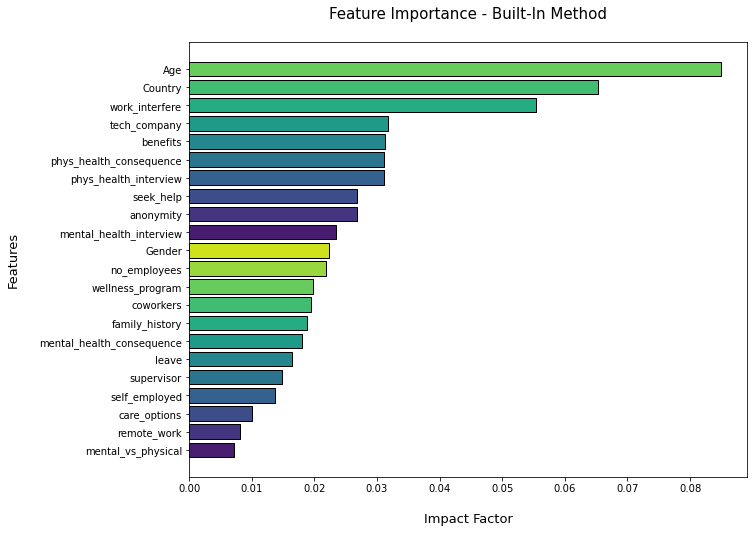

In [24]:
# Library Feature Importance Calculation:

featurenameslib = []
featureimplib = []

featureimplib = t.feature_importances_

for index, value in enumerate(featureimplib):
    featurenameslib.append(df.columns[index])
    np.append(featureimplib, value)
    
featuredflib = pd.DataFrame()

featuredflib["featurenames"] = featurenameslib
featuredflib["featureimp"] = featureimplib

featuredflib = featuredflib.drop(featuredflib[featuredflib.featurenames == "treatment"].index)

display(featuredflib)

plt.figure(figsize = (10, 8))

plt.barh('featurenames', 'featureimp', data = featuredflib.sort_values('featureimp'), edgecolor = 'black', color = 
         sns.color_palette("viridis", len('featurenames')))

plt.xlabel("\nImpact Factor", size = 13)
plt.ylabel("Features\n", size = 13)

plt.title("Feature Importance - Built-In Method\n", size = 15)

In [26]:
# Result Calculation:

print("\nFinal Accuracy: {0:.4f} ".format(metrics.accuracy_score(y_test, y_pred)))

# Training and Testing accuracies:

print("\nTraining Accuracy: {0:.4f} ".format(t.score(X_train, y_train)))
print("\nTesting Accuracy: {0:.4f}".format(t.score(X_test, y_test)))

# Detailed Classification Report:

print("\nClassification Report: - \n\n", classification_report(y_test, y_pred))


Final Accuracy: 0.7841 

Training Accuracy: 1.0000 

Testing Accuracy: 0.7841

Classification Report: - 

               precision    recall  f1-score   support

           0       0.76      0.81      0.78       153
           1       0.81      0.76      0.78       162

    accuracy                           0.78       315
   macro avg       0.78      0.78      0.78       315
weighted avg       0.79      0.78      0.78       315



[Text(657.9739766725352, 1057.0, 'work_interfere <= 2.5\nentropy = 1.0\nsamples = 944\nvalue = [469, 475]\nclass = 1'),
 Text(351.81998239436615, 996.6, 'work_interfere <= 1.5\nentropy = 0.828\nsamples = 471\nvalue = [348, 123]\nclass = ['),
 Text(251.73855633802813, 936.2, 'work_interfere <= 0.5\nentropy = 0.981\nsamples = 286\nvalue = [166, 120]\nclass = ['),
 Text(137.53521126760563, 875.8, 'mental_health_consequence <= 0.5\nentropy = 0.563\nsamples = 174\nvalue = [151, 23]\nclass = ['),
 Text(54.031690140845065, 815.4000000000001, 'mental_health_interview <= 0.5\nentropy = 0.811\nsamples = 64\nvalue = [48, 16]\nclass = ['),
 Text(44.20774647887323, 755.0, 'entropy = 0.0\nsamples = 9\nvalue = [9, 0]\nclass = ['),
 Text(63.8556338028169, 755.0, 'care_options <= 0.5\nentropy = 0.87\nsamples = 55\nvalue = [39, 16]\nclass = ['),
 Text(39.29577464788732, 694.6, 'no_employees <= 4.5\nentropy = 0.65\nsamples = 24\nvalue = [20, 4]\nclass = ['),
 Text(19.64788732394366, 634.2, 'no_employees 

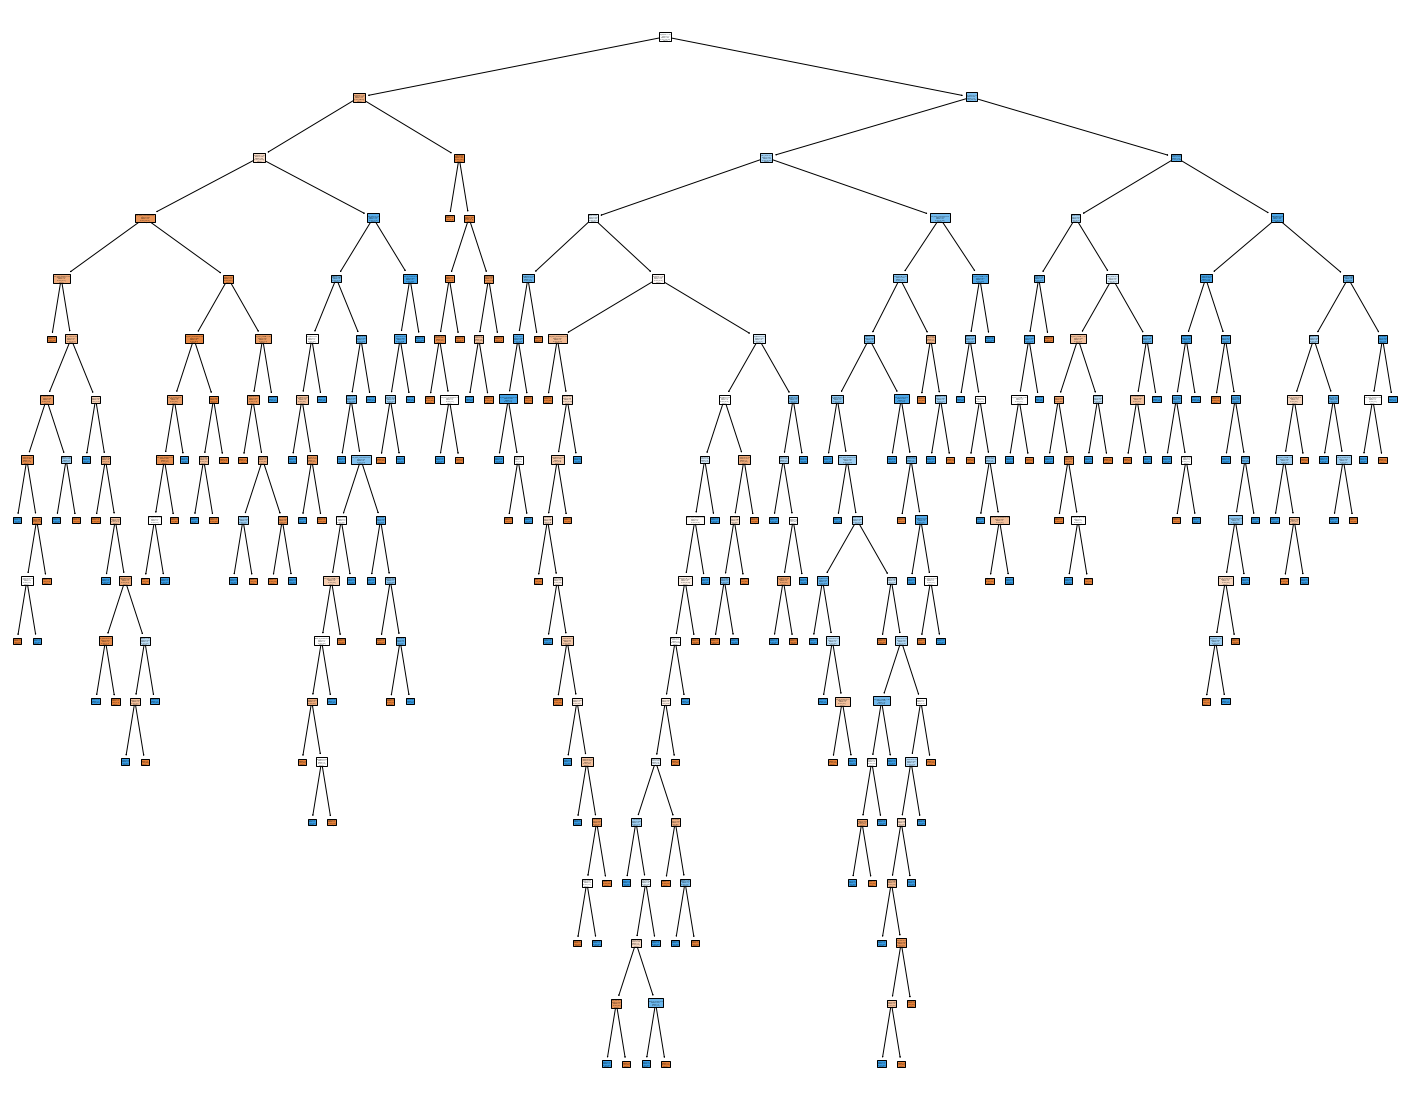

In [27]:
# Plotting the sklearn tree to provide a visual on how large the tree can be built:

fig = plt.figure(figsize = (25, 20))

tree.plot_tree(t, feature_names = X.columns.values, class_names = str(list(Y.unique())), filled = True)

## Implementation using ID3 Exhaustive Search Algorithm: 

#### Minimizing 'Entropy' Objective Function:

<img src="Part 2/images/1.png" />

#### Maximizing 'Overall Loss in Entropy' Objective Function:

<img src="Part 2/images/2.png" />

#### The Sub-Algorithms:

<table><tr>
    
<td> <img src="Part 2/images/A1.jpg" style="width: 350px;"/> </td>

<td> <img src="Part 2/images/A2.jpg" style="width: 350px;"/> </td>
    
<td> <img src="Part 2/images/A3.jpg" style="width: 350px;"/> </td>

</tr></table>

<table><tr>
    
<td> <img src="Part 2/images/A4.jpg" style="width: 350px;"/> </td>

<td> <img src="Part 2/images/A5.jpg" style="width: 350px;"/> </td>

<td> <img src="Part 2/images/A6.jpg" style="width: 350px;"/> </td>

</tr></table>

In [28]:
# Note: The class structure outline is followed as Andrew NG's Tutorial on Deep Learning Models.

class decisiontree():
    
    def __init__(self, data_df, max_depth, min_samples):
        
        self.data_df = data_df
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.columnfs = data_df.columns
        self.dti = self.generatetree(self.data_df.values, 0)
        
    def puresplitchk(self, data):
        
        uvp = np.unique(data[:, -1])
        
        if len(uvp) == 1:
            return True
        else:
            return False

    def classifier(self, data):
        
        allclass, classcount = np.unique(data[:, -1], return_counts = True)
        maxcc = classcount.argmax()
        classes = allclass[maxcc]
        
        return classes
    
    def minentropyloss(self, leftnoded, rightnoded):
        
        extra, classcount = np.unique(leftnoded[:, -1], return_counts = True)
        prob = classcount / classcount.sum()
        entropy1 = -1 * np.sum(prob * np.log2(prob))
        
        extra, classcount = np.unique(rightnoded[:, -1], return_counts = True)
        prob = classcount / classcount.sum()
        entropy2 = -1 * np.sum(prob * np.log2(prob))
        
        noden = len(leftnoded) + len(rightnoded)
        
        dsleft = len(leftnoded) / noden
        n1 = dsleft * entropy1
        
        dsright = len(rightnoded) / noden
        n2 = dsright * entropy2
        
        delis = n1 + n2
        
        return dsleft, dsright, delis

    def maxoverallentropyloss(self, data, ps):
        
        oventropy = 10000
        
        bestcolsplit = 0
        bestvalsplit = 0
        
        for colsplit in ps:
            for valsplit in ps[colsplit]:
                
                leftdata, rightdata = self.splitting(data, colsplit, valsplit)
                
                # Note: The lprob, rprob is the outcome of employing Algorithm 6.
                
                lprob, rprob, newoventropy = self.minentropyloss(leftdata, rightdata)
                
                if newoventropy <= oventropy:
                    oventropy = newoventropy
                    
                    bestcolsplit = colsplit
                    bestvalsplit = valsplit
                
                # Note: The only variation from Algorithm 6 that has been done here is that instead of the value 0.5 
                # (since it is averaged out as such when generating the actual tree), the comparison is b/w the lower 
                # and higher probability, and a decision is made accordingly, as seen below.
                
                # These returned probailities are from the Linear Programming functions I am trying to minimize / maximize.
                    
                if lprob < rprob:
                    fprob = rprob
                if lprob > rprob:
                    fprob = lprob
                if lprob == rprob:
                    fprob = lprob
                    
        return fprob, bestcolsplit, bestvalsplit

    def splitting(self, data, colsplit, valsplit):
        
        colsplitvals = data[:, colsplit]
        
        left = data[colsplitvals <= valsplit]
        right = data[colsplitvals > valsplit]
        
        return left, right
    
    def queryvalue(self, cname, valsplit):
    
        if cname == "Gender":
            return genderdf.loc[genderdf.TransformedValue == valsplit, 'OriginalValue'].values[0]
        
        if cname == "work_interfere":
            return widf.loc[widf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == "Country":
            return countrydf.loc[countrydf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'self_employed':
            return sedf.loc[sedf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'family_history':
            return fhdf.loc[countrydf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'no_employees':
            return nedf.loc[nedf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'remote_work':
            return rwdf.loc[rwdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'tech_company':
            return tcdf.loc[tcdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'benefits':
            return benefitsdf.loc[benefitsdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'care_options':
            return caredf.loc[caredf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'wellness_program':
            return wpdf.loc[wpdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'seek_help':
            return shdf.loc[shdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'anonymity':
            return anondf.loc[anondf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'leave':
            return leavedf.loc[leavedf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'mental_health_consequence':
            return mhcdf.loc[mhcdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'phys_health_consequence':
            return phcdf.loc[phcdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'coworkers':
            return coworkdf.loc[coworkdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'supervisor':
            return supervisordf.loc[supervisordf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'mental_health_interview':
            return mhidf.loc[mhidf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'phys_health_interview':
            return phidf.loc[phidf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'mental_vs_physical':
            return mvpdf.loc[mvpdf.TransformedValue == valsplit, 'OriginalValue'].values[0]

        if cname == 'obs_consequence':
            return oconseqdf.loc[oconseqdf.TransformedValue == valsplit, 'OriginalValue'].values[0]
        
    def generatetree(self, data, depth):
        
        if (depth == self.max_depth):
            valreturn = self.classifier(data)
            return valreturn
        
        elif (len(data) < self.min_samples):
            valreturn = self.classifier(data)
            return valreturn
        
        elif (self.puresplitchk(data)):
            valreturn = self.classifier(data)
            return valreturn
            
        else:
            depth += 1
            
            ps = {}
            num_cols = data.shape[1]
            cindex = list(range(num_cols - 1))
            
            for ci in cindex:
                values = data[:, ci]
                uv = np.unique(values)
                
                if len(uv) == 1:
                    ps[ci] = uv
                else:
                    ps[ci] = []
                    
                    for i in range(1, len(uv)):
                        pastval = uv[i - 1]
                        presval = uv[i]
                        meanval = (presval + pastval) // 2
                        ps[ci].append(meanval)
            
            # Note: The colsplit, valsplit is the outcome of employing a combination of Algorithm 5, 3 and 2 
            # (and inherently Algorithm 1). Notice that the loss function I am trying to maximize is operating
            # in a loop, thus it is exhaustively (i.e. power set) creating instead a relevant KB directly from a DT.
            
            fprob, colsplit, valsplit = self.maxoverallentropyloss(data, ps)
            
            cname = self.data_df.columns[colsplit]
            
            realvalue = self.queryvalue(cname, valsplit)
            
            if d == 1:
                pass
            else:
                
                # Note: The following is the output returned from employing a combination of Algorithm 5, 3 ad 2 
                # (and inherently Algorithm 1). The KB is provided forth in this manner.
                
                print("Best Feature is = '{}',".format(cname), "with Value = '{}'".format(realvalue), "and Probability = '{0:.4f}'".format(fprob))

            featuredf.loc[featuredf.featurenames == cname, 'featureimp'] += 1 
            
            leftdata, rightdata = self.splitting(data, colsplit, valsplit)
            
            if len(leftdata) == 0:
                return self.classifier(data)
            
            elif len(rightdata) == 0:
                return self.classifier(data)
            
            else:
                equalitychk = str(self.columnfs[colsplit]) + " <= " + str(valsplit)
                st = {equalitychk: []}
                
                leftf = self.generatetree(leftdata, depth)
                rightf = self.generatetree(rightdata, depth)
                
                if leftf == rightf:
                    st = leftf
                else:
                    st[equalitychk].append(leftf)
                    st[equalitychk].append(rightf)
                    
                return st

    def testclassifier(self, testsplit, st):
        
        if not isinstance(st, dict):
            return st
        
        equalitychk = list(st.keys())[0]
        feature, featureval = equalitychk.split(" <= ")
        
        if testsplit[feature] <= float(featureval):
            result = st[equalitychk][0]
        else:
            result = st[equalitychk][1]
            
        final = self.testclassifier(testsplit, result)
        
        return final

    def predict(self, testdata):
        
        pred = testdata.apply(self.testclassifier, axis = 1, args = (self.dti, ))
                        
        return pred

## Actual Run: 

In [29]:
print("\nBased on the 'Entropy' metric for ID3-DT, this decision tree provides the following:")

d = 1
check = 0
prevtrainaccuracy = 0

while check < 3:
    
    dt = decisiontree(traindata, d, 2)
    
    traintrue = traindata.iloc[:, -1]
    trainpred = dt.predict(traindata)
    trainaccuracy = metrics.accuracy_score(traintrue, trainpred)
    
    testtrue = testdata.iloc[:, -1]
    testpred = dt.predict(testdata)
    testaccuracy = metrics.accuracy_score(testtrue, testpred)
    
    # Note: The majorclass is the outcome of employing Algorithm 4, where the strings act as 0, 1 instead.
    
    tn, fp, fn, tp = confusion_matrix(testtrue, testpred).ravel()
    
    #print("Positive Class: ", tp)
    #print("Negative Class: ", tn)
    
    if tp > tn:
        majorclass = "Positive Class"
        
    if tp < tn:
        majorclass = "Negative Class"
    
    if tp == tn:
        majorclass = "Both Classes"
    
    print("\nAt Depth Level = {}, ".format(d), "Train Accuracy Achieved = {0:.4f}, ".format(trainaccuracy), "Test Accuracy Achieved = {0:.4f}".format(testaccuracy))
    
    if prevtrainaccuracy != trainaccuracy:
        check = 0
    else:
        check += 1
        
    if check < 3:
        print("The following query rules provide with Good Prediction of {}".format(majorclass), "(Positive: {}, Negative: {}).\n".format(tp, tn))
        print("In BFS order: ")
    else:
        pass
    
    prevtrainaccuracy = trainaccuracy
    d += 1


Based on the 'Entropy' metric for ID3-DT, this decision tree provides the following:

At Depth Level = 1,  Train Accuracy Achieved = 0.7415,  Test Accuracy Achieved = 0.7746
The following query rules provide with Good Prediction of Positive Class (Positive: 128, Negative: 116).

In BFS order: 
Best Feature is = 'work_interfere', with Value = 'Prefer Not To Say' and Probability = '0.8538'
Best Feature is = 'work_interfere', with Value = 'Often' and Probability = '0.8811'
Best Feature is = 'care_options', with Value = 'Not sure' and Probability = '0.8266'

At Depth Level = 2,  Train Accuracy Achieved = 0.7415,  Test Accuracy Achieved = 0.7746
The following query rules provide with Good Prediction of Positive Class (Positive: 128, Negative: 116).

In BFS order: 
Best Feature is = 'work_interfere', with Value = 'Prefer Not To Say' and Probability = '0.8538'
Best Feature is = 'work_interfere', with Value = 'Often' and Probability = '0.8811'
Best Feature is = 'work_interfere', with Value = 

Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.6000'
Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.8171'
Best Feature is = 'no_employees', with Value = '6-25' and Probability = '0.8174'
Best Feature is = 'Country', with Value = 'United Kingdom' and Probability = '0.8421'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.7692'
Best Feature is = 'anonymity', with Value = 'Don't know' and Probability = '0.8163'
Best Feature is = 'mental_vs_physical', with Value = 'Don't know' and Probability = '0.8261'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.8077'

At Depth Level = 6,  Train Accuracy Achieved = 0.8612,  Test Accuracy Achieved = 0.7429
The following query rules provide with Good Prediction of Negative Class (Positive: 102, Negative: 132).

In BFS order: 
Best Feature is = 'work_interfere', with Value = 'Prefer Not To Say' and Probability = '0.8538'
Best Feature is = 'work_interfere', with Value

Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.9565'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.9333'
Best Feature is = 'leave', with Value = 'Somewhat difficult' and Probability = '0.9091'
Best Feature is = 'care_options', with Value = 'Not sure' and Probability = '0.7232'
Best Feature is = 'coworkers', with Value = 'No' and Probability = '0.7857'
Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.9167'
Best Feature is = 'tech_company', with Value = 'No' and Probability = '0.8889'
Best Feature is = 'seek_help', with Value = 'Don't know' and Probability = '0.8571'
Best Feature is = 'anonymity', with Value = 'No' and Probability = '0.7500'
Best Feature is = 'supervisor', with Value = 'No' and Probability = '0.8182'
Best Feature is = 'mental_health_consequence', with Value = 'Maybe' and Probability = '0.8462'
Best Feature is = 'anonymity', with Value = 'Don't know' and Probability = '0.6607'
Best Fe

Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.9167'
Best Feature is = 'tech_company', with Value = 'No' and Probability = '0.8889'
Best Feature is = 'seek_help', with Value = 'Don't know' and Probability = '0.8571'
Best Feature is = 'anonymity', with Value = 'No' and Probability = '0.7500'
Best Feature is = 'supervisor', with Value = 'No' and Probability = '0.8182'
Best Feature is = 'mental_health_consequence', with Value = 'Maybe' and Probability = '0.8462'
Best Feature is = 'phys_health_interview', with Value = 'No' and Probability = '0.9000'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.8125'
Best Feature is = 'anonymity', with Value = 'Don't know' and Probability = '0.6607'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '0.7368'
Best Feature is = 'mental_vs_physical', with Value = 'Don't know' and Probability = '0.7500'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.9459'
Best Feature is

Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '0.7273'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.7000'
Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.5000'
Best Feature is = 'Gender', with Value = 'Female' and Probability = '0.9605'
Best Feature is = 'benefits', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.9565'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.9333'
Best Feature is = 'leave', with Value = 'Somewhat difficult' and Probability = '0.9091'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '0.8889'
Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'care_options', with Value = 'Not sure' and Probability = '0.7232'
Best Feature is = 'coworkers', with Value = 'No' and Probability = '0.78

Best Feature is = 'phys_health_interview', with Value = 'Maybe' and Probability = '0.8000'
Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.6667'
Best Feature is = 'benefits', with Value = 'No' and Probability = '0.8000'
Best Feature is = 'seek_help', with Value = 'No' and Probability = '0.8333'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.8077'
Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '1.0000'

At Depth Level = 10,  Train Accuracy Achieved = 0.9587,  Test Accuracy Achieved = 0.7778
The following query rules provide with Good Prediction of Negative Class (Positive: 122, Negative: 123).

In BFS order: 
Best Feature is = 'work_interfere', with Value = 'Prefer Not To Say' and Probability = '0.8538'
Best Feature is = 'work_interfere', with Value = 'Often' and Probability = '0.8811'
Best Feature is = 'work_interfere', with Value = 'Never' and Probability = '0.8392'
Best Feature is = 'mental_health_consequence

Best Feature is = 'Country', with Value = 'Czech Republic' and Probability = '0.9070'
Best Feature is = 'no_employees', with Value = '26-100' and Probability = '0.9500'
Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '0.9130'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '1.0000'
Best Feature is = 'self_employed', with Value = 'Unknown' and Probability = '1.0000'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '1.0000'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.5714'
Best Feature is = 'phys_health_interview', with Value = 'No' and Probability = '0.6667'
Best Feature is = 'phys_health_interview', with Value = 'Maybe' and Probability = '0.7692'
Best Feature is = 'benefits', with Value = 'Don't know' and Probability = '0.8125'
Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.7500'
Best Feature is = 'Country', with Value = 'United Kingdom' and Pr

Best Feature is = 'seek_help', with Value = 'No' and Probability = '0.7778'
Best Feature is = 'phys_health_consequence', with Value = 'No' and Probability = '0.7647'
Best Feature is = 'leave', with Value = 'Somewhat easy' and Probability = '1.0000'
Best Feature is = 'work_interfere', with Value = 'Rarely' and Probability = '0.8761'
Best Feature is = 'phys_health_consequence', with Value = 'Maybe' and Probability = '0.9062'
Best Feature is = 'seek_help', with Value = 'No' and Probability = '0.9167'
Best Feature is = 'self_employed', with Value = 'No' and Probability = '0.9091'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.8947'
Best Feature is = 'Country', with Value = 'Japan' and Probability = '0.8824'
Best Feature is = 'leave', with Value = 'Somewhat difficult' and Probability = '0.9286'
Best Feature is = 'wellness_program', with Value = 'Don't know' and Probability = '1.0000'
Best Feature is = 'self_employed', with Value = 'No' and Probability = '0.8642'
Best Feat

Best Feature is = 'care_options', with Value = 'No' and Probability = '0.8545'
Best Feature is = 'no_employees', with Value = '6-25' and Probability = '0.9167'
Best Feature is = 'no_employees', with Value = '1-5' and Probability = '0.9048'
Best Feature is = 'Gender', with Value = 'Female' and Probability = '0.9000'
Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'supervisor', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'Country', with Value = 'United Kingdom' and Probability = '0.8065'
Best Feature is = 'benefits', with Value = 'Don't know' and Probability = '0.8462'
Best Feature is = 'supervisor', with Value = 'No' and Probability = '0.8000'
Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.7647'
Best Feature is = 'benefits', with Value = 'No' and Probability = '0.7500'
Best Feature is = 'coworkers', with Value = 'No' and Probability = '0.8000'
Best Feature is = 'leave', with Value = 'Somew

Best Feature is = 'benefits', with Value = 'No' and Probability = '0.9091'
Best Feature is = 'no_employees', with Value = '6-25' and Probability = '0.8889'
Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '0.9130'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '1.0000'
Best Feature is = 'self_employed', with Value = 'Unknown' and Probability = '1.0000'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '1.0000'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.5714'
Best Feature is = 'phys_health_interview', with Value = 'No' and Probability = '0.6667'
Best Feature is = 'phys_health_interview', with Value = 'Maybe' and Probability = '0.7692'
Best Feature is = 'benefits', with Value = 'Don't know' and Probability = '0.8125'
Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.7500'
Best Feature is = 'Country', with Value = 'United Kingdom' and Probability = '

Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.9412'
Best Feature is = 'no_employees', with Value = '1-5' and Probability = '1.0000'
Best Feature is = 'anonymity', with Value = 'Don't know' and Probability = '1.0000'
Best Feature is = 'care_options', with Value = 'Not sure' and Probability = '0.8266'
Best Feature is = 'family_history', with Value = 'No' and Probability = '0.8519'
Best Feature is = 'Gender', with Value = 'Female' and Probability = '0.8647'
Best Feature is = 'self_employed', with Value = 'Unknown' and Probability = '0.8000'
Best Feature is = 'seek_help', with Value = 'No' and Probability = '0.7778'
Best Feature is = 'phys_health_consequence', with Value = 'No' and Probability = '0.7647'
Best Feature is = 'leave', with Value = 'Somewhat easy' and Probability = '1.0000'
Best Feature is = 'work_interfere', with Value = 'Rarely' and Probability = '0.8761'
Best Feature is = 'phys_health_consequence', with Value = 'Maybe' and Probability = '0.9062'

Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '1.0000'

At Depth Level = 14,  Train Accuracy Achieved = 0.9947,  Test Accuracy Achieved = 0.7714
The following query rules provide with Good Prediction of Negative Class (Positive: 118, Negative: 125).

In BFS order: 
Best Feature is = 'work_interfere', with Value = 'Prefer Not To Say' and Probability = '0.8538'
Best Feature is = 'work_interfere', with Value = 'Often' and Probability = '0.8811'
Best Feature is = 'work_interfere', with Value = 'Never' and Probability = '0.8392'
Best Feature is = 'mental_health_consequence', with Value = 'Maybe' and Probability = '0.9138'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.8750'
Best Feature is = 'care_options', with Value = 'No' and Probability = '0.8545'
Best Feature is = 'no_employees', with Value = '6-25' and Probability = '0.9167'
Best Feature is = 'no_employees', with Value = '1-5' and Probability = '0.9048'
Best Feature

Best Feature is = 'mental_health_consequence', with Value = 'Maybe' and Probability = '0.9091'
Best Feature is = 'leave', with Value = 'Somewhat difficult' and Probability = '0.8750'
Best Feature is = 'phys_health_interview', with Value = 'Maybe' and Probability = '0.8333'
Best Feature is = 'supervisor', with Value = 'No' and Probability = '0.6667'
Best Feature is = 'mental_health_consequence', with Value = 'No' and Probability = '0.8394'
Best Feature is = 'wellness_program', with Value = 'No' and Probability = '0.8673'
Best Feature is = 'coworkers', with Value = 'Some of them' and Probability = '0.8901'
Best Feature is = 'no_employees', with Value = '1-5' and Probability = '0.8824'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.9000'
Best Feature is = 'Gender', with Value = 'Female' and Probability = '0.8909'
Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.8333'
Best Feature is = 'mental_vs_physical', with Value = 'No' an

Best Feature is = 'anonymity', with Value = 'No' and Probability = '0.7500'
Best Feature is = 'supervisor', with Value = 'No' and Probability = '0.8182'
Best Feature is = 'mental_health_consequence', with Value = 'Maybe' and Probability = '0.8462'
Best Feature is = 'phys_health_interview', with Value = 'No' and Probability = '0.9000'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.8750'
Best Feature is = 'mental_vs_physical', with Value = 'Don't know' and Probability = '1.0000'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.8125'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '0.7143'
Best Feature is = 'benefits', with Value = 'Don't know' and Probability = '0.8333'
Best Feature is = 'anonymity', with Value = 'Don't know' and Probability = '0.6607'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '0.7368'
Best Feature is = 'mental_vs_physical', with Value = 'Don't know' and Probability = '0

Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.6000'
Best Feature is = 'mental_vs_physical', with Value = 'Don't know' and Probability = '1.0000'
Best Feature is = 'coworkers', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.8171'
Best Feature is = 'no_employees', with Value = '6-25' and Probability = '0.8174'
Best Feature is = 'Country', with Value = 'United Kingdom' and Probability = '0.8421'
Best Feature is = 'mental_vs_physical', with Value = 'Don't know' and Probability = '0.7273'
Best Feature is = 'phys_health_interview', with Value = 'Maybe' and Probability = '1.0000'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.7692'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.7632'
Best Feature is = 'leave', with Value = 'Somewhat difficult' and Probability = '0.6111'
Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.5000'
Best F

Best Feature is = 'mental_health_consequence', with Value = 'Maybe' and Probability = '0.8846'
Best Feature is = 'Country', with Value = 'United Kingdom' and Probability = '0.7778'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '0.6000'
Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.6000'
Best Feature is = 'phys_health_consequence', with Value = 'Maybe' and Probability = '1.0000'
Best Feature is = 'mental_health_interview', with Value = 'No' and Probability = '0.6000'
Best Feature is = 'leave', with Value = 'Somewhat easy' and Probability = '0.9412'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.9600'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '1.0000'
Best Feature is = 'phys_health_consequence', with Value = 'Maybe' and Probability = '0.9524'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '1.0000'
Best Feature is = 'leave

Best Feature is = 'phys_health_consequence', with Value = 'Maybe' and Probability = '0.9310'
Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '0.7273'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.7000'
Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.5000'
Best Feature is = 'Gender', with Value = 'Female' and Probability = '0.9605'
Best Feature is = 'benefits', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.9565'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.9333'
Best Feature is = 'leave', with Value = 'Somewhat difficult' and Probability = '0.9091'
Best Feature is = 'supervisor', with Value = 'Some of them' and Probability = '0.8889'
Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'care_options', with Value = 'Not sure' and Pr

Best Feature is = 'phys_health_interview', with Value = 'Maybe' and Probability = '0.7692'
Best Feature is = 'benefits', with Value = 'Don't know' and Probability = '0.8125'
Best Feature is = 'obs_consequence', with Value = 'No' and Probability = '0.7500'
Best Feature is = 'Country', with Value = 'United Kingdom' and Probability = '1.0000'
Best Feature is = 'supervisor', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'Country', with Value = 'Thailand' and Probability = '0.7931'
Best Feature is = 'family_history', with Value = 'No' and Probability = '0.6923'
Best Feature is = 'mental_health_interview', with Value = 'No' and Probability = '0.7368'
Best Feature is = 'no_employees', with Value = '1-5' and Probability = '0.7059'
Best Feature is = 'seek_help', with Value = 'Don't know' and Probability = '0.6429'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.5833'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.7143'
B

Best Feature is = 'work_interfere', with Value = 'Rarely' and Probability = '0.8761'
Best Feature is = 'phys_health_consequence', with Value = 'Maybe' and Probability = '0.9062'
Best Feature is = 'seek_help', with Value = 'No' and Probability = '0.9167'
Best Feature is = 'self_employed', with Value = 'No' and Probability = '0.9091'
Best Feature is = 'Age', with Value = 'None' and Probability = '0.8947'
Best Feature is = 'Country', with Value = 'Japan' and Probability = '0.8824'
Best Feature is = 'leave', with Value = 'Somewhat difficult' and Probability = '0.9286'
Best Feature is = 'wellness_program', with Value = 'Don't know' and Probability = '1.0000'
Best Feature is = 'Age', with Value = 'None' and Probability = '1.0000'
Best Feature is = 'mental_health_consequence', with Value = 'Maybe' and Probability = '1.0000'
Best Feature is = 'supervisor', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'mental_vs_physical', with Value = 'Don't know' and Probability = '1.0000'
B

Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '1.0000'

At Depth Level = 19,  Train Accuracy Achieved = 1.0000,  Test Accuracy Achieved = 0.7746
The following query rules provide with Good Prediction of Negative Class (Positive: 119, Negative: 125).

In BFS order: 
Best Feature is = 'work_interfere', with Value = 'Prefer Not To Say' and Probability = '0.8538'
Best Feature is = 'work_interfere', with Value = 'Often' and Probability = '0.8811'
Best Feature is = 'work_interfere', with Value = 'Never' and Probability = '0.8392'
Best Feature is = 'mental_health_consequence', with Value = 'Maybe' and Probability = '0.9138'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.8750'
Best Feature is = 'care_options', with Value = 'No' and Probability = '0.8545'
Best Feature is = 'no_employees', with Value = '6-25' and Probability = '0.9167'
Best Feature is = 'no_employees', with Value = '1-5' and Probability = '0.9048'
Best Feature

Best Feature is = 'coworkers', with Value = 'Some of them' and Probability = '0.8901'
Best Feature is = 'no_employees', with Value = '1-5' and Probability = '0.8824'
Best Feature is = 'mental_health_interview', with Value = 'Maybe' and Probability = '0.9000'
Best Feature is = 'Gender', with Value = 'Female' and Probability = '0.8909'
Best Feature is = 'remote_work', with Value = 'No' and Probability = '0.8333'
Best Feature is = 'mental_vs_physical', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'phys_health_interview', with Value = 'No' and Probability = '1.0000'
Best Feature is = 'Country', with Value = 'Czech Republic' and Probability = '0.9070'
Best Feature is = 'no_employees', with Value = '26-100' and Probability = '0.9500'
Best Feature is = 'phys_health_interview', with Value = 'Maybe' and Probability = '1.0000'
Best Feature is = 'benefits', with Value = 'Don't know' and Probability = '1.0000'
Best Feature is = 'coworkers', with Value = 'No' and Probability = '1.

In [30]:
featuredf

,featurenames,featureimp
0,Age,175
1,Gender,71
2,Country,130
3,self_employed,56
4,family_history,35
5,work_interfere,83
6,no_employees,105
7,remote_work,69
8,tech_company,28
9,benefits,108


Text(0.5, 1.0, 'Feature Importance - Brute Force Method\n')

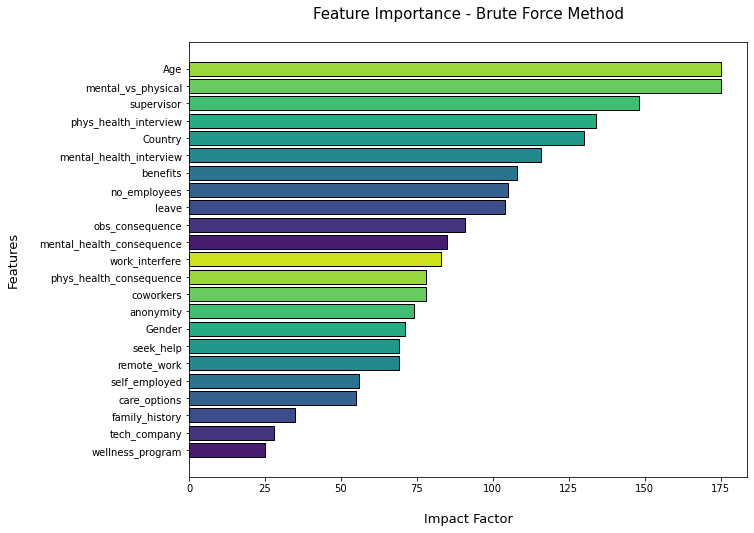

In [31]:
plt.figure(figsize = (10, 8))

plt.barh('featurenames', 'featureimp', data = featuredf.sort_values('featureimp'), edgecolor = 'black', color = 
         sns.color_palette("viridis", len('featurenames')))

plt.xlabel("\nImpact Factor", size = 13)
plt.ylabel("Features\n", size = 13)

plt.title("Feature Importance - Brute Force Method\n", size = 15)